**SETUP**

In [1]:
#SQL preperation

%load_ext sql
%sql sqlite:///cell_count.db

In [2]:
#All imports/loading requirements
from sklearn.linear_model import LogisticRegression
import pandas as pd
from scipy import stats
import sqlite3
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from google.colab import files
engine = create_engine("sqlite:///cell_count.db")

**Part 1: Data Management**
- Loading entire file in SQL relational database

In [3]:

#Downloading the origional cell_count csv file
df = pd.read_csv('https://raw.githubusercontent.com/mia2465/Technical/refs/heads/main/cell_count_personal.csv')
df = df.rename(columns={"subject": "subject_ID", "project": "project_ID","sample": "sample_ID","condition": "condition_diagnosis"})
print(df.info())

#Checking file/Reacreating in DataFrame
df.to_csv("cell_data_total.csv", index=False)
from google.colab import files
files.download("cell_data_total.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   project_ID                 10500 non-null  object
 1   subject_ID                 10500 non-null  object
 2   condition_diagnosis        10500 non-null  object
 3   age                        10500 non-null  int64 
 4   sex                        10500 non-null  object
 5   treatment                  10500 non-null  object
 6   response                   9078 non-null   object
 7   sample_ID                  10500 non-null  object
 8   sample_type                10500 non-null  object
 9   time_from_treatment_start  10500 non-null  int64 
 10  b_cell                     10500 non-null  int64 
 11  cd8_t_cell                 10500 non-null  int64 
 12  cd4_t_cell                 10500 non-null  int64 
 13  nk_cell                    10500 non-null  int64 
 14  monocy

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [4]:
#Transferring dataframe to SQL table

df.to_sql(
    "origional",
    engine,
    if_exists="replace",
    index=False
)

10500

In [5]:
#SCHEMA for the sql table

%%sql
-- Subject table
DROP TABLE IF EXISTS subject;
CREATE TABLE subject (
    subject_ID TEXT PRIMARY KEY,
    age INT,
    sex TEXT,
    treatment TEXT,
    condition_diagnosis TEXT,
    project_ID TEXT
);

-- Sample table
DROP TABLE IF EXISTS sample;
CREATE TABLE sample (
    sample_ID TEXT PRIMARY KEY,
    response TEXT,
    sample_type TEXT,
    time_from_treatment_start INT,
    b_cell	INT,
    cd8_t_cell INT,
    cd4_t_cell INT,
    nk_cell	INT,
    monocyte INT
);

DROP TABLE IF EXISTS subject_sample;
CREATE TABLE subject_sample (
    subject_ID TEXT REFERENCES subject(subject_ID),
    sample_ID TEXT REFERENCES sample(sample_ID),
    PRIMARY KEY (subject_ID, sample_ID)
);


 * sqlite:///cell_count.db
Done.
Done.
Done.
Done.
Done.
Done.


[]

In [6]:
#Populating the tables with required information

%%sql
--Populating tables
INSERT INTO subject (subject_ID,age,sex,treatment,condition_diagnosis, project_ID)
SELECT DISTINCT subject_ID,
       age,
       sex,
       treatment,
       condition_diagnosis,
       project_ID
FROM origional;

INSERT INTO sample (sample_ID,response,sample_type,time_from_treatment_start,b_cell, cd8_t_cell, cd4_t_cell,nk_cell,monocyte)
SELECT DISTINCT sample_ID,
       response,
       sample_type,
       time_from_treatment_start,
       b_cell,
       cd8_t_cell,
       cd4_t_cell,
       nk_cell,
       monocyte
FROM origional;

INSERT INTO subject_sample (subject_ID,sample_ID)
SELECT DISTINCT subject_ID,
       sample_ID
FROM origional;

 * sqlite:///cell_count.db
3500 rows affected.
10500 rows affected.
10500 rows affected.


[]

In [7]:
#Querrying/Checking functionality of entire data set/reational tables

query ="""
SELECT *
FROM subject sub JOIN subject_sample ss ON sub.subject_ID = ss.subject_ID
JOIN sample sam ON sam.sample_ID = ss.sample_ID
"""
dfSQL = pd.read_sql(query, engine)
print(dfSQL.info())
print(dfSQL.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   subject_ID                 10500 non-null  object
 1   age                        10500 non-null  int64 
 2   sex                        10500 non-null  object
 3   treatment                  10500 non-null  object
 4   condition_diagnosis        10500 non-null  object
 5   project_ID                 10500 non-null  object
 6   subject_ID                 10500 non-null  object
 7   sample_ID                  10500 non-null  object
 8   sample_ID                  10500 non-null  object
 9   response                   9078 non-null   object
 10  sample_type                10500 non-null  object
 11  time_from_treatment_start  10500 non-null  int64 
 12  b_cell                     10500 non-null  int64 
 13  cd8_t_cell                 10500 non-null  int64 
 14  cd4_t_

**Part 2: Initial Analysis - Data Overview**

In [8]:
#Query for table showing relative cell populations per cell type per sample
query ="""
WITH b_cell_population AS (SELECT s.sample_ID, 'b_cell' AS population, b_cell AS cell_population
                          FROM sample s),
cd8_t_cell_population AS (SELECT s.sample_ID, 'cd8_t_cell' AS population, cd8_t_cell AS cell_population
                          FROM sample s),
cd4_t_cell_population AS (SELECT s.sample_ID, 'cd4_t_cell' AS population, cd4_t_cell AS cell_population
                          FROM sample s),
nk_cell_population AS (SELECT s.sample_ID, 'nk_cell' AS population, nk_cell AS cell_population
                          FROM sample s),
monocyte_population AS (SELECT s.sample_ID, 'monocyte' AS population, monocyte AS cell_population
                          FROM sample s),
total_cell_counts AS (SELECT s.sample_ID, (b_cell + cd8_t_cell + cd4_t_cell + nk_cell + monocyte) as total_count
                        FROM sample s)
SELECT tcc.sample_ID, tcc.total_count, entire_populations.population, entire_populations.cell_population, (entire_populations.cell_population * 1.0)/tcc.total_count AS percentage
FROM (SELECT * FROM b_cell_population
UNION ALL SELECT * FROM cd8_t_cell_population
UNION ALL SELECT * FROM cd4_t_cell_population
UNION ALL SELECT * FROM nk_cell_population
UNION ALL SELECT * FROM monocyte_population) AS entire_populations
JOIN total_cell_counts tcc ON tcc.sample_ID = entire_populations.sample_ID
"""
dfSQL = pd.read_sql(query, engine)
print(dfSQL.info())
print(dfSQL.head(30000))

dfSQL.to_csv("initial_analysis.csv", index=False)
from google.colab import files
files.download("initial_analysis.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52500 entries, 0 to 52499
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_ID        52500 non-null  object 
 1   total_count      52500 non-null  int64  
 2   population       52500 non-null  object 
 3   cell_population  52500 non-null  int64  
 4   percentage       52500 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 2.0+ MB
None
         sample_ID  total_count  population  cell_population  percentage
0      sample00000        93214      b_cell            10908    0.117021
1      sample00001       100824      b_cell             6777    0.067216
2      sample00002        92822      b_cell             9794    0.105514
3      sample00003        93160      b_cell            10081    0.108212
4      sample00004       107903      b_cell             4372    0.040518
...            ...          ...         ...              ...     

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Part 3: Statistical Analysis**

In [9]:
#Query for cell percentages and response for samples

query ="""
WITH total_cell_counts AS (SELECT s.sample_ID, (s.b_cell + s.cd8_t_cell + s.cd4_t_cell + s.nk_cell + s.monocyte) as total_count
                        FROM sample s)
SELECT s.sample_ID, s.response,b_cell*1.0/tcc.total_count AS b,cd8_t_cell*1.0/tcc.total_count AS cd8_t,cd4_t_cell*1.0/tcc.total_count AS cd4_t,nk_cell*1.0/tcc.total_count AS nk,monocyte*1.0/tcc.total_count AS monocyte
FROM sample s JOIN total_cell_counts tcc ON s.sample_ID = tcc.sample_ID
WHERE s.sample_type = 'PBMC'
"""

dfSQL = pd.read_sql(query, engine)
print(dfSQL.info())
print(dfSQL.head(30000))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_ID  7500 non-null   object 
 1   response   6495 non-null   object 
 2   b          7500 non-null   float64
 3   cd8_t      7500 non-null   float64
 4   cd4_t      7500 non-null   float64
 5   nk         7500 non-null   float64
 6   monocyte   7500 non-null   float64
dtypes: float64(5), object(2)
memory usage: 410.3+ KB
None
        sample_ID response         b     cd8_t     cd4_t        nk  monocyte
0     sample00000       no  0.117021  0.262192  0.219827  0.148733  0.252226
1     sample00001       no  0.067216  0.192484  0.331856  0.180215  0.228229
2     sample00002       no  0.105514  0.247140  0.261511  0.188339  0.197496
3     sample00003      yes  0.108212  0.217593  0.388117  0.150719  0.135359
4     sample00004      yes  0.040518  0.313040  0.354884  0.153165  0.138393
...          

In [10]:
#Logistic Regression model to try to predict treatment outcome

model = LogisticRegression(solver='liblinear') # Instantiate the model
cell_pupulations = dfSQL[['b','cd8_t','cd4_t','nk','monocyte']]
print(cell_pupulations)
dfSQL['response'] = (
        dfSQL['response']
        .fillna('')
        .astype(str)
        .str.lower()
        .str.contains('y')
        .astype(int)
)
response = dfSQL['response']
print(response)
model.fit(cell_pupulations, response)

intercept = model.intercept_[0]
coefficients = model.coef_[0]

print(f"Intercept (b0): {intercept}")
print(f"Coefficients (b1, b2, ...): {coefficients}")

print('Logistic euqation for predicting response based on cell percentages in sample(assuming null is no response): b0 =-0.4982510890322582, [b, cd8_t, cd4_t, nk ,monocyte] =  [-1.83214622 -0.44636613  2.01727346  0.12665097 -0.36366317]')

             b     cd8_t     cd4_t        nk  monocyte
0     0.117021  0.262192  0.219827  0.148733  0.252226
1     0.067216  0.192484  0.331856  0.180215  0.228229
2     0.105514  0.247140  0.261511  0.188339  0.197496
3     0.108212  0.217593  0.388117  0.150719  0.135359
4     0.040518  0.313040  0.354884  0.153165  0.138393
...        ...       ...       ...       ...       ...
7495  0.089564  0.343453  0.224073  0.124843  0.218068
7496  0.072492  0.269791  0.304556  0.147177  0.205984
7497  0.080013  0.283699  0.252901  0.178367  0.205020
7498  0.097912  0.276888  0.308722  0.108203  0.208275
7499  0.100175  0.314874  0.289651  0.139529  0.155771

[7500 rows x 5 columns]
0       0
1       0
2       0
3       1
4       1
       ..
7495    0
7496    0
7497    0
7498    0
7499    0
Name: response, Length: 7500, dtype: int64
Intercept (b0): -0.4982510890322582
Coefficients (b1, b2, ...): [-1.83214622 -0.44636613  2.01727346  0.12665097 -0.36366317]
Logistic euqation for predicting res

In [11]:
## Analysis for cell populations on whether they responded or not to treatment
#b_cell
query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'no' AND pc.population = 'b_cell'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
b_cell_NoResponse = df['percentage']

query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'yes' AND pc.population = 'b_cell'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
b_cell_YesResponse = df['percentage']

#cd8_t_cell
query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'no' AND pc.population = 'cd8_t_cell'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
cd8_t_cell_NoResponse = df['percentage']

query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'yes' AND pc.population = 'cd8_t_cell'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
cd8_t_cell_YesResponse = df['percentage']

#cd4_t_cell
query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'no' AND pc.population = 'cd4_t_cell'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
cd4_t_cell_NoResponse = df['percentage']

query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'yes' AND pc.population = 'cd4_t_cell'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
cd4_t_cell_YesResponse = df['percentage']

#nk_cell
query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'no' AND pc.population = 'nk_cell'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
nk_cell_NoResponse = df['percentage']

query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'yes' AND pc.population = 'nk_cell'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
nk_cell_YesResponse = df['percentage']


#monocyte
query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'no' AND pc.population = 'monocyte'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
monocyte_NoResponse = df['percentage']

query ="""
SELECT pc.percentage
FROM sample s JOIN population_comparisons pc ON pc.sample_ID = s.sample_ID
WHERE s.response = 'yes' AND pc.population = 'monocyte'
"""
df = pd.read_sql(query, engine)
print(df.info())
print(df.head(5))
monocyte_YesResponse = df['percentage']

Responses = [b_cell_NoResponse,b_cell_YesResponse,
             cd8_t_cell_NoResponse,cd8_t_cell_YesResponse,
             cd4_t_cell_NoResponse,cd4_t_cell_YesResponse,
             nk_cell_NoResponse, nk_cell_YesResponse,
             monocyte_NoResponse, monocyte_YesResponse ]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4467 entries, 0 to 4466
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   percentage  4467 non-null   float64
dtypes: float64(1)
memory usage: 35.0 KB
None
   percentage
0   11.702105
1    6.721614
2   10.551378
3    5.910357
4   10.569577
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4611 entries, 0 to 4610
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   percentage  4611 non-null   float64
dtypes: float64(1)
memory usage: 36.2 KB
None
   percentage
0   10.821168
1    4.051787
2   14.646115
3   12.892981
4    9.755407
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4467 entries, 0 to 4466
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   percentage  4467 non-null   float64
dtypes: float64(1)
memory usage: 35.0 KB
None
   perc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

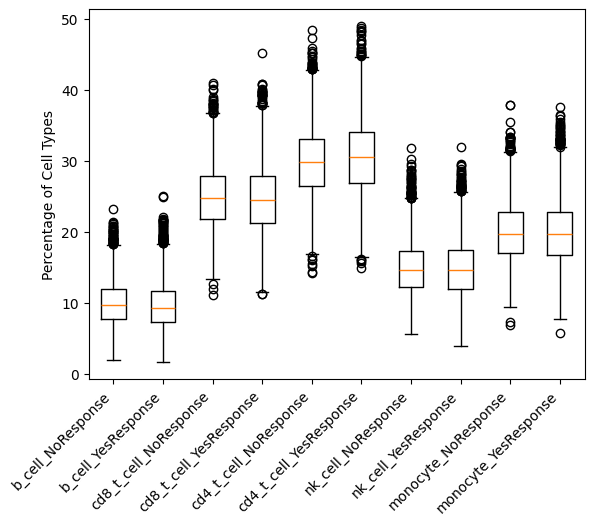

In [12]:
# Boxplot results of population response data

plt.boxplot(Responses)
plt.ylabel('Percentage of Cell Types')
plt.xticks(rotation=45, ha='right')
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9,10], ['b_cell_NoResponse','b_cell_YesResponse',
             'cd8_t_cell_NoResponse', 'cd8_t_cell_YesResponse',
             'cd4_t_cell_NoResponse','cd4_t_cell_YesResponse',
             'nk_cell_NoResponse', 'nk_cell_YesResponse',
             'monocyte_NoResponse', 'monocyte_YesResponse' ])

plt.savefig('Boxplot_Comparison.png', dpi=300,bbox_inches="tight")
files.download('Boxplot_Comparison.png')
plt.show()

In [13]:
#Statistical tests for if cell populations are different between responding or non responding popoulations

t_stat_b_cell, p_val_b_cell = stats.ttest_ind(b_cell_NoResponse, b_cell_YesResponse)
print(t_stat_b_cell, p_val_b_cell)
t_stat_cd8_t_cell, p_val_cd8_t_cell = stats.ttest_ind(cd8_t_cell_NoResponse, cd8_t_cell_YesResponse)
print(t_stat_cd8_t_cell, p_val_cd8_t_cell)
t_stat_cd4_t_cell, p_val_cd4_t_cell = stats.ttest_ind(cd4_t_cell_NoResponse, cd4_t_cell_YesResponse)
print(t_stat_cd4_t_cell, p_val_cd4_t_cell)
t_stat_nk_cell, p_val_nk_cell = stats.ttest_ind(nk_cell_NoResponse, nk_cell_YesResponse)
print(t_stat_nk_cell, p_val_nk_cell)
t_stat_monocyte, p_val_monocyte = stats.ttest_ind(monocyte_NoResponse, monocyte_YesResponse)
print(t_stat_monocyte, p_val_monocyte)

print('cell types b_cell,cd8_t_cell, and cd4_t_cell show significant differences in realtive frequencies, each with a p < .05. nk and monocyte cells do not')

data = {
    'cell': ['b_cell', 'cd8_t_cell', 'cd4_t_cell', 'nk_cell','monocyte'],
    'p_val': [p_val_b_cell, p_val_cd8_t_cell, p_val_cd4_t_cell, p_val_nk_cell,p_val_monocyte]
}
df = pd.DataFrame(data)
df.to_csv("p_values.csv", index=False)
from google.colab import files
files.download("p_values.csv")

4.545302667283205 5.556617418283021e-06
2.1394397678179873 0.032426665116402034
-6.444209408340438 1.221158771945813e-10
0.9082173092000557 0.36378753523494034
0.9610120548322958 0.3365717078094447
cell types b_cell,cd8_t_cell, and cd4_t_cell show significant differences in realtive frequencies, each with a p < .05. nk and monocyte cells do not


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Part 4 Data Subset Analysis:**

In [14]:
#Query for Sub sample analysis for PBMC start of treatment baseline for miraclib

query ="""
SELECT *
FROM  subject sub JOIN subject_sample ss ON sub.subject_ID = ss.subject_ID
JOIN sample sam ON sam.sample_ID = ss.sample_ID
WHERE sam.sample_type = 'PBMC' AND sam.time_from_treatment_start = 0 AND sub.treatment = 'miraclib'
"""

dfSQL = pd.read_sql(query, engine)
print(dfSQL.info())
print(dfSQL.head())
df.to_csv("sub_query.csv", index=False)
from google.colab import files
files.download("sub_query.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   subject_ID                 1143 non-null   object
 1   age                        1143 non-null   int64 
 2   sex                        1143 non-null   object
 3   treatment                  1143 non-null   object
 4   condition_diagnosis        1143 non-null   object
 5   project_ID                 1143 non-null   object
 6   subject_ID                 1143 non-null   object
 7   sample_ID                  1143 non-null   object
 8   sample_ID                  1143 non-null   object
 9   response                   1143 non-null   object
 10  sample_type                1143 non-null   object
 11  time_from_treatment_start  1143 non-null   int64 
 12  b_cell                     1143 non-null   int64 
 13  cd8_t_cell                 1143 non-null   int64 
 14  cd4_t_ce

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

How many samples from each project

How many subjects were responders/non-responders

How many subjects were males/females

In [15]:
#Query for which samples in sub query are part of which projects

query ="""
SELECT project_ID, COUNT(project_ID) AS numberSamples
FROM sub_population
GROUP BY project_ID
"""

dfSQL = pd.read_sql(query, engine)
print(dfSQL.info())
print(dfSQL.head())

dfSQL.to_csv("sub_query_project.csv", index=False)
from google.colab import files
files.download("sub_query_project.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   project_ID     2 non-null      object
 1   numberSamples  2 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 164.0+ bytes
None
  project_ID  numberSamples
0       prj1            697
1       prj3            446


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
#Query for which samples in sub query responded or not

query ="""
WITH yes AS(SELECT COUNT(sample_ID) AS number_yes
      FROM  sub_population s
      WHERE s.response = 'yes'),
      no AS(SELECT COUNT(sample_ID) AS number_no
      FROM  sub_population s
      WHERE s.response = 'no')
SELECT yes.number_yes, no.number_no
FROM yes, no
"""

dfSQL = pd.read_sql(query, engine)
print(dfSQL.info())
print(dfSQL.head())

dfSQL.to_csv("sub_query_responders.csv", index=False)
from google.colab import files
files.download("sub_query_responders.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   number_yes  1 non-null      int64
 1   number_no   1 non-null      int64
dtypes: int64(2)
memory usage: 148.0 bytes
None
   number_yes  number_no
0         569        574


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [17]:
#Query for male/female ratio of sub query
query ="""
WITH female AS(SELECT COUNT(s.subject_ID) AS num_female
      FROM  sub_population s
      WHERE s.sex = 'F'),
      male AS(SELECT COUNT(s.subject_ID) AS num_male
      FROM  sub_population s
      WHERE s.sex = 'M')
SELECT female.num_female, male.num_male
FROM female, male
"""

dfSQL = pd.read_sql(query, engine)
print(dfSQL.info())
print(dfSQL.head())

dfSQL.to_csv("sub_query_gender.csv", index=False)
from google.colab import files
files.download("sub_query_gender.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_female  1 non-null      int64
 1   num_male    1 non-null      int64
dtypes: int64(2)
memory usage: 148.0 bytes
None
   num_female  num_male
0         550       593


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
#Query to find the average amount of b_cells for male melenoma patients.

query ="""
SELECT AVG(sam.b_cell)
FROM  subject sub JOIN subject_sample ss ON sub.subject_ID = ss.subject_ID
JOIN sample sam ON sam.sample_ID = ss.sample_ID
WHERE sub.sex = 'M' AND sub.condition_diagnosis = 'melanoma' AND sam.response = 'yes' AND sam.time_from_treatment_start = 0
"""

dfSQL = pd.read_sql(query, engine)
print(dfSQL.info())
print(dfSQL.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 1 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   AVG(sam.b_cell)  1 non-null      float64
dtypes: float64(1)
memory usage: 140.0 bytes
None
   AVG(sam.b_cell)
0     10206.150515
